Denoising rows: 100%|██████████| 1024/1024 [05:54<00:00,  2.89it/s]



Pixel count: 1048576
PSNR (noisy):    20.023 dB
PSNR (denoised): 23.304 dB


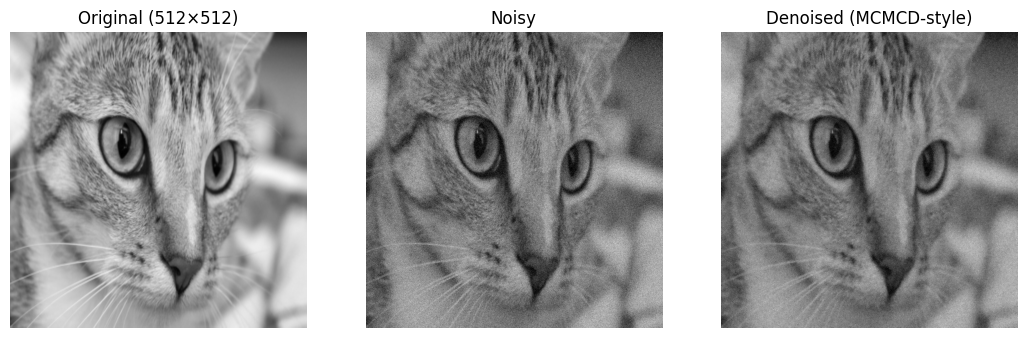

In [17]:
# MCMCD-style image denoising (Jupyter-ready, with progress bars)
# ---------------------------------------------------------------
# Config:
IMAGE_PATH = None            # e.g. "my_photo.jpg" (in same folder). If None, a random image is used.
OUTPUT_SIZE = 1024            # final working size (use 512 as requested)
SIGMA_NOISE = 0.10           # noise std on [0,1] scale (~0.10 ≈ 25/255)
K_SAMPLES   = 32             # samples per pixel (increase for better quality, but it's slower)
PATCH_R     = 1              # patch radius: 1 -> 3x3, 2 -> 5x5
SIGMA_S     = 3            # spatial sampling std (pixels)
RNG_SEED    = 0

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, color, transform, data
from scipy.ndimage import uniform_filter

# ---------- Helpers ----------
def to_float01(img):
    img = img.astype(np.float32)
    if img.max() > 1.5:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def psnr(gt, est):
    mse = np.mean((gt - est) ** 2)
    if mse == 0:
        return 99.0
    return 10.0 * np.log10(1.0 / mse)

def load_image_1024(image_path=None, size=1024, rng=None):
    if image_path is not None:
        img = io.imread(image_path)
    else:
        # pick a random built-in image
        choices = [
            data.camera(),      # gray
            data.astronaut(),   # color
            data.coffee(),      # color
            data.chelsea(),     # color
        ]
        idx = rng.integers(0, len(choices))
        img = choices[idx]
    # to grayscale
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = to_float01(img)
    # resize to exactly size×size
    img = transform.resize(img, (size, size), order=1, mode='reflect', anti_aliasing=True)
    return img

def pad_reflect(img, r):
    return np.pad(img, r, mode="reflect")

def extract_patch(padded, x, y, r):
    return padded[x:x+2*r+1, y:y+2*r+1]

def geman_mcclure_weight(p_ref, p_cand, sigma_n, s_local):
    # Eq. inspired weighting on patch difference
    diff2  = (p_cand - p_ref) ** 2
    denom  = (sigma_n**2) * (s_local**2) + diff2
    return np.exp(-np.sum(diff2 / denom))

def mcmcd_importance_denoise(noisy, K=32, r=1, sigma_s=3.0, sigma_n=0.08, seed=0):
    """
    Importance-weighted sampler (no accept/reject for speed/stability).
    For each pixel s, draw K candidate sites from N(s, sigma_s^2 I),
    weight by Geman–McClure patch similarity, return weighted mean intensity.
    """
    H, W = noisy.shape
    den = np.zeros_like(noisy, dtype=np.float32)
    padded = pad_reflect(noisy, r)

    # local variance map (rough; used as s_local)
    mu  = uniform_filter(noisy, size=2*r+1, mode='reflect')
    var = uniform_filter(noisy**2, size=2*r+1, mode='reflect') - mu**2
    var = np.clip(var, 1e-6, None)
    s_local = np.sqrt(var)

    rng = np.random.default_rng(seed)

    for x in tqdm(range(H), desc="Denoising rows", leave=True):
        for y in range(W):
            pref = extract_patch(padded, x, y, r)
            s_loc = s_local[x, y]

            dx = rng.normal(0.0, sigma_s, size=K)
            dy = rng.normal(0.0, sigma_s, size=K)
            xs = np.clip((x + dx).astype(int), 0, H-1)
            ys = np.clip((y + dy).astype(int), 0, W-1)

            weights = np.empty(K, dtype=np.float32)
            vals    = np.empty(K, dtype=np.float32)
            for i in range(K):
                pc = extract_patch(padded, xs[i], ys[i], r)
                weights[i] = geman_mcclure_weight(pref, pc, sigma_n, s_loc)
                vals[i]    = noisy[xs[i], ys[i]]

            wsum = np.sum(weights) + 1e-12
            den[x, y] = float(np.sum(weights * vals) / wsum)

    return den

# ---------- Load / prepare ----------
rng = np.random.default_rng(RNG_SEED)
orig = load_image_1024(IMAGE_PATH, size=OUTPUT_SIZE, rng=rng)
pixels = orig.size

# ---------- Add Gaussian noise ----------
noisy = np.clip(orig + rng.normal(0, SIGMA_NOISE, orig.shape).astype(np.float32), 0, 1)

# ---------- Denoise ----------
denoised = mcmcd_importance_denoise(
    noisy,
    K=K_SAMPLES,
    r=PATCH_R,
    sigma_s=SIGMA_S,
    sigma_n=SIGMA_NOISE,
    seed=RNG_SEED
)

# ---------- Report + show ----------
print(f"Pixel count: {pixels}")
print(f"PSNR (noisy):    {psnr(orig, noisy):.3f} dB")
print(f"PSNR (denoised): {psnr(orig, denoised):.3f} dB")

fig, axes = plt.subplots(1, 3, figsize=(13,4))
axes[0].imshow(orig, cmap='gray');    axes[0].set_title("Original (512×512)"); axes[0].axis('off')
axes[1].imshow(noisy, cmap='gray');   axes[1].set_title("Noisy");              axes[1].axis('off')
axes[2].imshow(denoised, cmap='gray');axes[2].set_title("Denoised (MCMCD-style)"); axes[2].axis('off')
plt.show()
